# Imports

In [ ]:
import torch
import torch.nn as nn
from random import shuffle
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

from torchvision.datasets import FashionMNIST
import torchvision.transforms as T

from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA available! Training on GPU.", flush=True)
else:
    device = torch.device('cpu')
    print("CUDA NOT available... Training on CPU.", flush=True)

CUDA available! Training on GPU.


# Problem 2

In [ ]:
# Load the dataset
data = pd.read_csv('Email_data.csv')  # Replace with the actual path
data.head()

,Unnamed: 0,file,message
0,427616,shackleton-s/sent/1912.,Message-ID: <21013688.1075844564560.JavaMail.e...
1,108773,farmer-d/logistics/1066.,Message-ID: <22688499.1075854130303.JavaMail.e...
2,355471,parks-j/deleted_items/202.,Message-ID: <27817771.1075841359502.JavaMail.e...
3,457837,stokley-c/chris_stokley/iso/client_rep/41.,Message-ID: <10695160.1075858510449.JavaMail.e...
4,124910,germany-c/all_documents/1174.,Message-ID: <27819143.1075853689038.JavaMail.e...


In [ ]:
# Email Text
data['message'].head(2)

,message
0,Message-ID: <21013688.1075844564560.JavaMail.e...
1,Message-ID: <22688499.1075854130303.JavaMail.e...


In [ ]:
# Example Email
print(data['message'].iloc[0][:550])

Message-ID: <21013688.1075844564560.JavaMail.evans@thyme>
Date: Tue, 29 Aug 2000 01:26:00 -0700 (PDT)
From: sara.shackleton@enron.com
To: william.bradford@enron.com
Subject: Re: Credit Derivatives
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Sara Shackleton
X-To: William S Bradford
X-cc: 
X-bcc: 
X-Folder: \Sara_Shackleton_Dec2000_June2001_1\Notes Folders\Sent
X-Origin: SHACKLETON-S
X-FileName: sshackle.nsf

Bill:  Thanks for the info.   I also spoke with Jeff about how 
EnronCredit.com Lt


In [ ]:
# Split the dataset into training and testing sets
train_set, test_set = train_test_split(data, test_size=0.333, random_state=42)

In [ ]:
# Select 100 random samples from each set for the attacks
fine_tune_samples = train_set.sample(n=100, random_state=42)
test_samples = test_set.sample(n=100, random_state=42)

In [ ]:
# Load the Pythia-70M model and tokenizer
model_name = "EleutherAI/pythia-70m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')
pretrain = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
        

In [ ]:
for param in model.gpt_neox.parameters():
    param.requires_grad = False

In [ ]:
def check_requires_grad(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.requires_grad}")

check_requires_grad(model)

gpt_neox.embed_in.weight: False
gpt_neox.layers.0.input_layernorm.weight: False
gpt_neox.layers.0.input_layernorm.bias: False
gpt_neox.layers.0.post_attention_layernorm.weight: False
gpt_neox.layers.0.post_attention_layernorm.bias: False
gpt_neox.layers.0.attention.query_key_value.weight: False
gpt_neox.layers.0.attention.query_key_value.bias: False
gpt_neox.layers.0.attention.dense.weight: False
gpt_neox.layers.0.attention.dense.bias: False
gpt_neox.layers.0.mlp.dense_h_to_4h.weight: False
gpt_neox.layers.0.mlp.dense_h_to_4h.bias: False
gpt_neox.layers.0.mlp.dense_4h_to_h.weight: False
gpt_neox.layers.0.mlp.dense_4h_to_h.bias: False
gpt_neox.layers.1.input_layernorm.weight: False
gpt_neox.layers.1.input_layernorm.bias: False
gpt_neox.layers.1.post_attention_layernorm.weight: False
gpt_neox.layers.1.post_attention_layernorm.bias: False
gpt_neox.layers.1.attention.query_key_value.weight: False
gpt_neox.layers.1.attention.query_key_value.bias: False
gpt_neox.layers.1.attention.dense.weig

In [ ]:
# Tokenize the dataset
tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(examples):
    tokenized_inputs = tokenizer(examples['message'].tolist(),
                                 max_length=1024,
                                 padding=True,
                                 truncation=True,
                                 return_tensors="pt").to('cuda')
    # Add labels for causal language modeling
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].clone()
    return tokenized_inputs

train_encodings = tokenize_function(train_set)
test_encodings = tokenize_function(test_set)

train_dataset = Dataset.from_dict(train_encodings)
test_dataset = Dataset.from_dict(test_encodings)

In [ ]:
# Fine-tune the model
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=10,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    # weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
)

trainer.train()

Step,Training Loss
500,1.694800
1000,1.437100


TrainOutput(global_step=1250, training_loss=1.528507763671875, metrics={'train_runtime': 623.7391, 'train_samples_per_second': 16.032, 'train_steps_per_second': 2.004, 'total_flos': 2744584765440000.0, 'train_loss': 1.528507763671875, 'epoch': 10.0})

In [ ]:
trainer.save_model('tuned_model')

In [ ]:
!zip -r tuned_model.zip tuned_model/

  adding: tuned_model/ (stored 0%)
  adding: tuned_model/model.safetensors
	zip warning:  file size changed while zipping tuned_model/model.safetensors
 (deflated 30%)
  adding: tuned_model/training_args.bin (deflated 51%)
  adding: tuned_model/generation_config.json (deflated 23%)
  adding: tuned_model/config.json (deflated 47%)


In [ ]:
model = AutoModelForCausalLM.from_pretrained("tuned_model")

In [ ]:
def calculate_perplexity(text, p_model = model):
    window_length=1024
    step_size=256

    losses = []
    for i in range (0, len(text), step_size):
        inputs = tokenizer(text[i:i+window_length], return_tensors='pt', truncation=True)
        input_ids = inputs['input_ids'].to('cuda')
        target_ids = input_ids.clone()

        with torch.no_grad():
            outputs = p_model(input_ids, labels=target_ids)

        losses.append(outputs.loss)

    ppl = torch.exp(torch.tensor(losses)).mean()
    return ppl.item()

In [ ]:
from tqdm import tqdm

pre_trained_ppl = []
fine_tuned_ppl = []

for i in tqdm(range(len(test_set))):
    pre_trained_ppl.append(calculate_perplexity(test_set.message.values[i], pretrain))
    fine_tuned_ppl.append(calculate_perplexity(test_set.message.values[i]))

100%|██████████| 500/500 [02:10<00:00,  3.82it/s]


In [ ]:
import math
pre_trained_ppl = [0 if math.isnan(x) else x for x in pre_trained_ppl]
fine_tuned_ppl = [0 if math.isnan(x) else x for x in fine_tuned_ppl]

In [ ]:
print(f"Average perplexity of pre-trained model is {sum(pre_trained_ppl)/len(pre_trained_ppl):.2f}")
print(f"Average perplexity of fine-tuned model is {sum(fine_tuned_ppl)/len(fine_tuned_ppl):.2f}")

Average perplexity of pre-trained model is 148.83
Average perplexity of fine-tuned model is 153.54


In [ ]:
# Calculate perplexity for attack samples

fine_tune_perplexities = []
test_perplexities = []

for i in tqdm(range(100)):
    fine_tune_perplexities.append(calculate_perplexity(fine_tune_samples.message.values[i]))
    test_perplexities.append(calculate_perplexity(test_samples.message.values[i]))

100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


In [ ]:
fine_tune_perplexities = [0 if math.isnan(x) else x for x in fine_tune_perplexities]
test_perplexities = [0 if math.isnan(x) else x for x in test_perplexities]

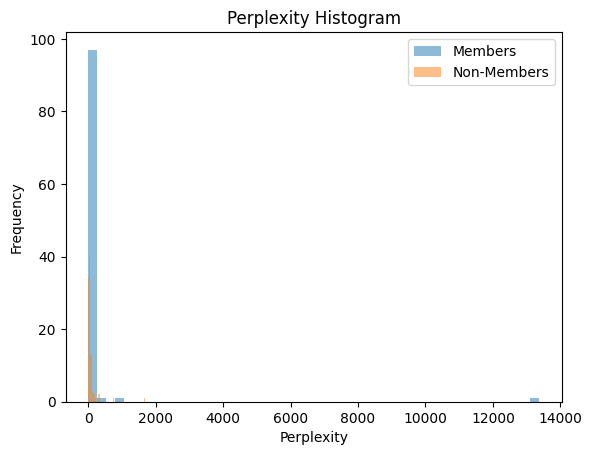

In [ ]:
# Plot histograms for perplexity-based attack
plt.hist(fine_tune_perplexities, alpha=0.5, label='Members', bins=50)
plt.hist(test_perplexities, alpha=0.5, label='Non-Members', bins=50)
plt.legend(loc='upper right')
plt.title('Perplexity Histogram')
plt.xlabel('Perplexity')
plt.ylabel('Frequency')
plt.show()

In [ ]:
fine_tune_perplexities_pretrain = []
test_perplexities_pretrain = []

for i in tqdm(range(100)):
    fine_tune_perplexities_pretrain.append(calculate_perplexity(fine_tune_samples.message.values[i], p_model=pretrain))
    test_perplexities_pretrain.append(calculate_perplexity(test_samples.message.values[i], p_model=pretrain))

100%|██████████| 100/100 [00:22<00:00,  4.46it/s]


In [ ]:
fine_tune_perplexities_pretrain = [0 if math.isnan(x) else x for x in fine_tune_perplexities_pretrain]
test_perplexities_pretrain = [0 if math.isnan(x) else x for x in test_perplexities_pretrain]

In [ ]:
# Calculate normalized perplexity for attack samples using pre-trained model perplexities

fine_tune_norm_ppl = []
test_norm_ppl = []

for i in range(100):
  if fine_tune_perplexities_pretrain[i] != 0:
    fine_tune_norm_ppl.append(fine_tune_perplexities[i]/fine_tune_perplexities_pretrain[i])
  else: fine_tune_norm_ppl.append(0)
  if test_perplexities_pretrain[i] != 0:
    test_norm_ppl.append(test_perplexities[i]/test_perplexities_pretrain[i])
  else: test_norm_ppl.append(0)

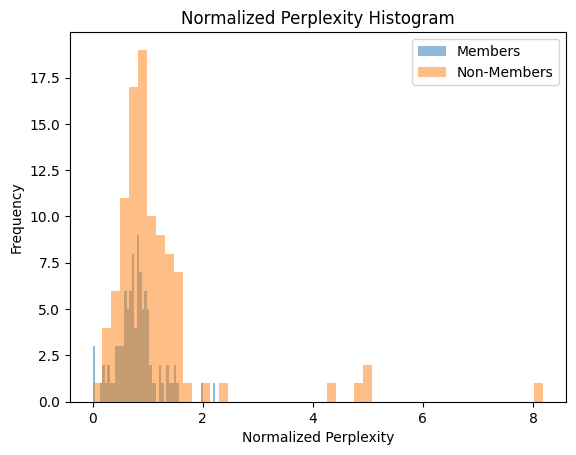

In [ ]:
# Plot histograms for normalized perplexity-based attack
plt.hist(fine_tune_norm_ppl, alpha=0.5, label='Members', bins=50)
plt.hist(test_norm_ppl, alpha=0.5, label='Non-Members', bins=50)
plt.legend(loc='upper right')
plt.title('Normalized Perplexity Histogram')
plt.xlabel('Normalized Perplexity')
plt.ylabel('Frequency')
plt.show()

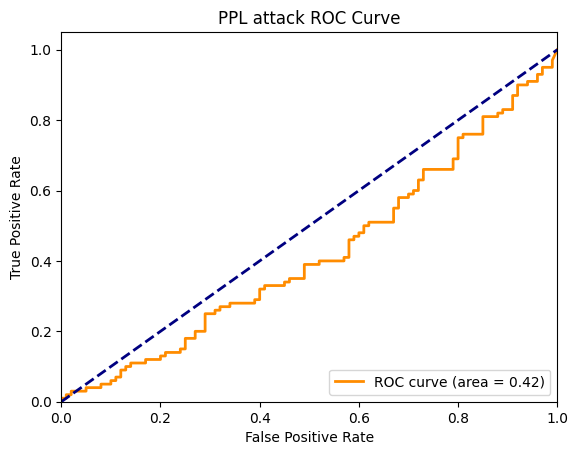

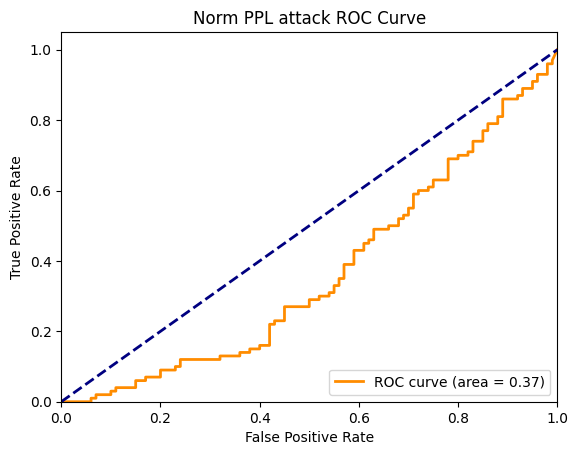

In [ ]:
# Calculate ROC curves and AUC scores for both attacks
def plot_roc_curve(true_labels, scores, attack_label):
    fpr, tpr, _thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(attack_label)
    plt.legend(loc="lower right")
    plt.show()

true_labels = [1] * 100 + [0] * 100

# Perplexity-based attack ROC curve
scores_ppl = np.concatenate((fine_tune_perplexities, test_perplexities))
plot_roc_curve(true_labels, scores_ppl, "PPL attack ROC Curve")

# Normalized perplexity-based attack ROC curve
scores_norm_ppl = np.concatenate((fine_tune_norm_ppl, test_norm_ppl))
plot_roc_curve(true_labels, scores_norm_ppl, "Norm PPL attack ROC Curve")

In [ ]:
# For Perplexity-based attack
fpr, tpr, _thresholds = roc_curve(true_labels, scores_ppl)

# Find the indices where fpr is close to 0.01
indices0_1 = max(np.argwhere(np.isclose(fpr, 0.0)))
indices1 = max(np.argwhere(np.isclose(fpr, 0.01)))
indices10 = max(np.argwhere(np.isclose(fpr, 0.1)))
# Print TPRs at various FPR Rates
print(tpr[indices0_1])
print(tpr[indices1])
print(tpr[indices10])

[0.01]
[0.02]
[0.06]


In [ ]:
y_pred = np.array(scores_ppl < np.mean(fine_tune_perplexities)).astype(int)

In [ ]:
# Average For Perplexity-based attack

tn, fp, fn, tp = confusion_matrix(true_labels, y_pred).ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + fp + tn + fn)
error = 1 - accuracy
precision = tp / (tp + fp)

In [ ]:
print(f"Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Accuracy: {accuracy:.2f}, Error: {error:.2f}, Precision: {precision:.2f}")

Confusion Matrix: TP=96, FP=94, TN=6, FN=4
Accuracy: 0.51, Error: 0.49, Precision: 0.51


In [ ]:
# Normalized perplexity-based attack ROC curve
fpr, tpr, _thresholds = roc_curve(true_labels, scores_norm_ppl)

# Find the indices where fpr is close to 0.01
indices0_1 = max(np.argwhere(np.isclose(fpr, 0.0)))
indices1 = max(np.argwhere(np.isclose(fpr, 0.01)))
indices10 = max(np.argwhere(np.isclose(fpr, 0.1)))
# Print TPRs at various FPR Rates
print(tpr[indices0_1])
print(tpr[indices1])
print(tpr[indices10])

[0.]
[0.]
[0.03]


In [ ]:
y_pred = np.array(scores_norm_ppl < np.mean(fine_tune_norm_ppl)).astype(int)

In [ ]:
# Average For Normalised Perplexity-based attack

tn, fp, fn, tp = confusion_matrix(true_labels, y_pred).ravel()

# Calculate metrics
accuracy = (tp + tn) / (tp + fp + tn + fn)
error = 1 - accuracy
precision = tp / (tp + fp)

In [ ]:
print(f"Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Accuracy: {accuracy:.2f}, Error: {error:.2f}, Precision: {precision:.2f}")

Confusion Matrix: TP=51, FP=37, TN=63, FN=49
Accuracy: 0.57, Error: 0.43, Precision: 0.58


## Observations

* The first attack uses raw perplexity values to infer membership, assuming that members will have lower perplexity.
* In the second attack normalizing perplexity relative to the pre-trained model helps control for inherent model biases.
* A relatively high error rate for both attacks suggests that the attack struggles to distinguish between members and non-members effectively.
* The attack has a strong bias towards predicting samples as members, indicated by the imbalance between TP and TN.
* The tpr rate at 0% , 1% and 10% are extremely low showing that the model has not been able to distinguish between members and non-members.

# Problem 3

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import random

In [ ]:
model.eval()

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
        

In [ ]:
# Set pad_token_id if not set
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [ ]:
# Function to generate text
def generate_text(prefix, max_length=1000):
    inputs = tokenizer(prefix, return_tensors='pt').to('cuda')
    outputs = model.generate(inputs['input_ids'],
                             attention_mask=inputs['attention_mask'],
                             max_length=max_length,
                             pad_token_id=tokenizer.pad_token_id,
                             eos_token_id=tokenizer.eos_token_id,
                             do_sample=True,
                             num_return_sequences=1,
                             temperature=0.7)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# Strategy 1: Random token prefix
def random_token_generation():
    vocab = list(tokenizer.get_vocab().keys())
    results = []
    for _ in range(10):
        random_token = random.choice(vocab)
        generated_text = generate_text(random_token, max_length=1000)
        results.append(generated_text)
    return results

In [ ]:
# Run Strategy 1
random_results = random_token_generation()
print("-----Strategy 1 Generated Outputs:-----")
for i, result in enumerate(random_results):
  print(f'\n\nGenerated output nmber {i}:')
  print(result[:1000])

-----Strategy 1 Generated Outputs:-----


Generated output nmber 0:
%%%%%%%%%%%%%%%%=
  \
    \
    \
    \
  \
    \
    \
    \
  \
    \
    \
  \
    \
    \
    \
    \
    \
  \
    \
    \
  \
    \
  \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
  \
    \
    \
    \
    \
  \
    \
    \
    \
    \
    \
    \
    \
    \
  \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    \
    

### Observations

* The model is mostly generating gibberish for most of the prefixes
* The model was able to leak some email addresses on some of the runs but reproducing that is difficult. These are likely coincidental rather than indicative of actual email content extraction.
* This shows that this attack is not effective most of the times for this model but you might get lucky sometimes.
* This strategy is generally not effective for extracting specific information or structured data like emails from the fine-tuned dataset due to the lack of contextual guidance.

In [ ]:
# Strategy 2: Partial email prefix
def partial_email_generation(emails, max_length=1000):
    results = []
    for email in emails:
        inputs = tokenizer(email, return_tensors='pt').to('cuda')
        inputs['input_ids'] = inputs['input_ids'][:,:500]
        inputs['attention_mask'] = inputs['attention_mask'][:,:500]
        outputs = model.generate(inputs['input_ids'],
                             attention_mask=inputs['attention_mask'],
                             max_length=max_length,
                             pad_token_id=tokenizer.pad_token_id,
                             eos_token_id=tokenizer.eos_token_id,
                             do_sample=True,
                             num_return_sequences=1,
                             temperature=0.7)
        results.append((email, tokenizer.decode(outputs[0], skip_special_tokens=True)))
    return results

In [ ]:
# Prepare emails for Strategy 2
fine_tune_emails = train_set.sample(n=10, random_state=42)['message'].tolist()
test_emails = test_set.sample(n=10, random_state=42)['message'].tolist()

In [ ]:
# Run Strategy 2 on IN and OUT emails
in_results = partial_email_generation(fine_tune_emails)
out_results = partial_email_generation(test_emails)

In [ ]:
for original, generated in out_results:
  print('Original Text: \n',original)
  print('Generated Text: \n',generated)
  print('\n\n\n\n')

Original Text: 
 Message-ID: <32496408.1075851726595.JavaMail.evans@thyme>
Date: Fri, 19 Jan 2001 08:21:00 -0800 (PST)
From: arsystem@mailman.enron.com
To: errol.mclaughlin@enron.com
Subject: Request Submitted: Access Request amelia.cavazos@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: ARSystem <ARSystem@mailman.enron.com>
X-To: "errol.mclaughlin@enron.com" <errol.mclaughlin@enron.com>
X-cc: 
X-bcc: 
X-Folder: \Errol_McLaughlin_Nov2001\Notes Folders\Security request
X-Origin: MCLAUGHLIN-E
X-FileName: emclaug.nsf

Thank you for your request. You will be notified by email when your request 
has been processed. You can check the progress of your request by clicking 
http://itcapps.corp.enron.com/srrs/auth/emailLink.asp?ID=000000000014511&Page=
MyReq.



Generated Text: 
 Message-ID: <32496408.1075851726595.JavaMail.evans@thyme>
Date: Fri, 19 Jan 2001 08:21:00 -0800 (PST)
From: arsystem@mailman.enron.com
To: errol.mclaughlin@

In [ ]:
for original, generated in in_results:
  print('Original Text: \n',original)
  print('Generated Text: \n',generated)
  print('\n\n\n\n')

Original Text: 
 Message-ID: <8386892.1075854378232.JavaMail.evans@thyme>
Date: Wed, 9 Aug 2000 07:25:00 -0700 (PDT)
From: darron.giron@enron.com
To: gary.stadler@enron.com
Subject: New FT Books
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Darron C Giron
X-To: Gary Stadler
X-cc: 
X-bcc: 
X-Folder: \Darron_Giron_Jun2001\Notes Folders\Discussion threads
X-Origin: Giron-D
X-FileName: dgiron.nsf

Gary,
We need to have two more books created as soon as possible.  These need to be 
set up the same as the others(not as PA books) Kam requested (moving from and 
Intra book to an FT book).

 FT-INT-CNT-TRANS
 FT-INT-EMWMEH

Call if you have any questions.  Thanks


DG
3-9573
Generated Text: 
 Message-ID: <8386892.1075854378232.JavaMail.evans@thyme>
Date: Wed, 9 Aug 2000 07:25:00 -0700 (PDT)
From: darron.giron@enron.com
To: gary.stadler@enron.com
Subject: New FT Books
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Trans

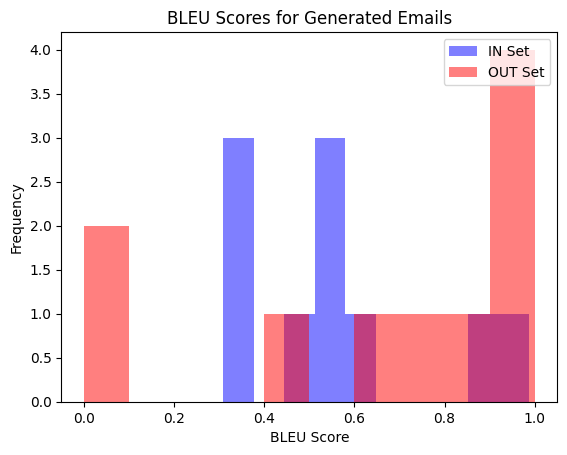

In [ ]:
# Calculate BLEU scores
def calculate_bleu_scores(results):
    scores = []
    for original, generated in results:
        reference = [original.split()]
        candidate = generated.split()
        score = sentence_bleu(reference, candidate)
        scores.append(score)
    return scores

in_bleu_scores = calculate_bleu_scores(in_results)
out_bleu_scores = calculate_bleu_scores(out_results)

# Plot BLEU scores histogram
plt.hist(in_bleu_scores, alpha=0.5, label='IN Set', color='blue')
plt.hist(out_bleu_scores, alpha=0.5, label='OUT Set', color='red')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')
plt.title('BLEU Scores for Generated Emails')
plt.legend(loc='upper right')
plt.show()

In [138]:
np.mean(in_bleu_scores)

0.6663686198046689

In [137]:
np.mean(out_bleu_scores)

0.5669437338299093

### Observations

* Using a partial email as a prefix provides a strong context, resulting in more coherent and relevant outputs that often continue the style and format of an email.
* Higher BLEU scores for emails from the fine-tuning set suggest that the model may have memorized or overfit certain patterns or phrases from these emails.
* Lower BLEU scores for emails outside the fine-tuning set indicate less similarity, as expected since these contexts were not part of the training data.
* Strategy 2 is more effective than Strategy 1 in generating text that resembles email content due to its use of contextual prefixes.
* The results emphasize the need for careful consideration of privacy when fine-tuning models on sensitive datasets, as they may inadvertently memorize and reproduce training data.